# Lab 05: Wine Quality

---
author: Katherine Mei
date: October 5, 2024
embed-resources: true
---

## Introduction

In this report, we will use wine data to develop an AI-based Sommelier, a model specializing in wine services, that will predict a wine's quality based on its physicochemical characteristics. To do so, we will create a predictive regression model that will use modified wine quality data accessible through the UC Irvine Machine Learning Repository.

## Methods

In [1]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# machine learning
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

### Data

In [2]:
# load data
wine_train = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-train.csv",
)
wine_test = pd.read_csv(
    "https://cs307.org/lab-05/data/wine-test.csv",
)

wine_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.6,0.23,0.64,12.9,0.033,54.0,170.0,0.99800,3.00,0.53,8.8,5,white
1,NaN,0.75,0.01,2.2,0.059,11.0,18.0,0.99242,3.39,0.40,NaN,6,red
2,7.4,0.67,0.12,1.6,0.186,5.0,21.0,0.99600,3.39,0.54,9.5,5,red
3,6.4,0.18,0.74,NaN,0.046,54.0,168.0,0.99780,3.58,0.68,10.1,5,white
4,6.7,0.35,0.32,9.0,0.032,29.0,113.0,0.99188,3.13,0.65,12.9,7,white
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4152,6.6,0.32,0.22,16.7,0.046,38.0,133.0,0.99790,3.22,0.67,10.4,6,white
4153,9.2,0.58,0.20,3.0,0.081,15.0,115.0,0.99800,3.23,0.59,9.5,5,red
4154,8.2,0.60,0.17,2.3,0.072,11.0,73.0,0.99630,3.20,0.45,9.3,5,red
4155,6.5,0.23,0.36,16.3,0.038,43.0,133.0,0.99924,3.26,0.41,8.8,5,white


In [3]:
# summary statistics
wine_train.shape

(4157, 13)

# Data Dictionary

Each observation in the train, test, and (hidden) production data contains information about a particular Portuguese “Vinho Verde” wine.

### Response
- **Quality** `int64`: the quality of the wine based on evaluation by a minimum of three sensory assessors (using blind tastes), which graded the wine in a scale that ranges from 0 (very bad) to 10 (excellent)

### Features
- **Color** `object`: The (human perceivable) color of the wine, red or white.
- **Fixed Acidity** `float64`: Grams of tartaric acid per cubic decimeter.
- **Volatile Acidity** `float64`: Grams of acetic acid per cubic decimeter.
- **Citric Acid** `float64`: Grams of citric acid per cubic decimeter.
- **Residual Sugar** `float64`: Grams of residual sugar per cubic decimeter.
- **Chlorides** `float64`: Grams of sodium chloride per cubic decimeter.
- **Free Sulfur Dioxide** `float64`: Milligrams of free sulfur dioxide per cubic decimeter.
- **Total Sulfur Dioxide** `float64`: Milligrams of total sulfur dioxide per cubic decimeter.
- **Density** `float64`: The total density of the wine in grams per cubic centimeter.
- **pH** `float64`: The acidity of the wine measured using pH.
- **Sulphates** `float64`: Grams of potassium sulphate per cubic decimeter.
- **Alcohol** `float64`: Percent alcohol by volume.

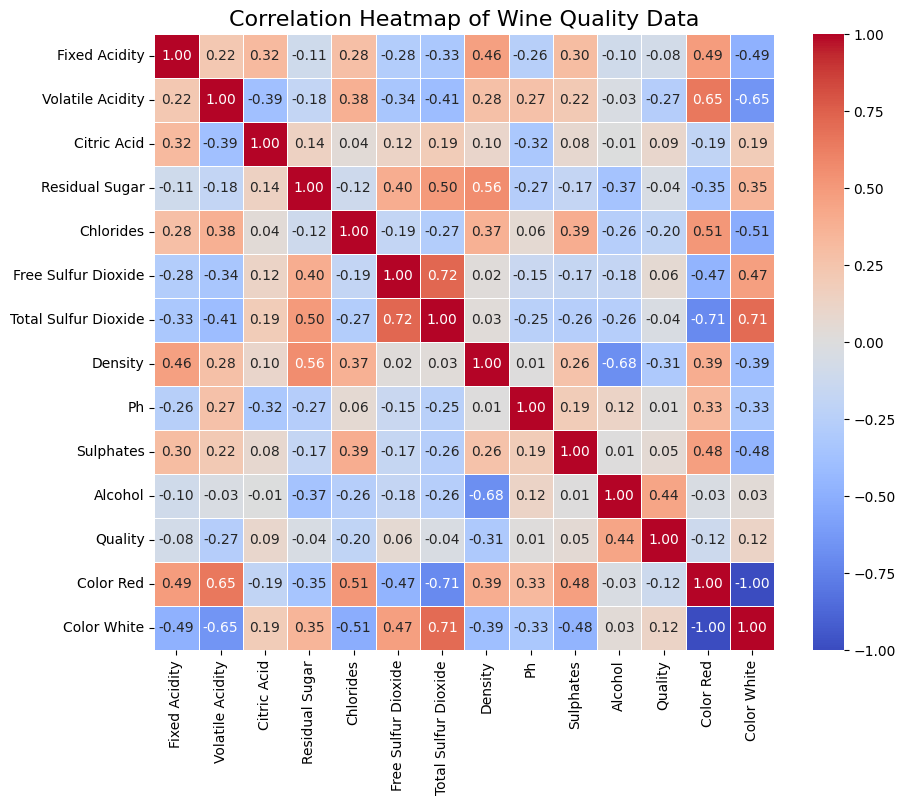

In [4]:
# visualizations
categorical_columns = wine_train.select_dtypes(include=['object']).columns

data = pd.get_dummies(wine_train, columns=categorical_columns)
data.columns = [col.replace('_', ' ').title() for col in data.columns]

correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Wine Quality Data", fontsize=16)
plt.show()

The visualization provides some insight into the data. The heatmap shows the relationships between different physicochemical properties of wine. 

The scale on the right represents the strength of the relationship. Red represents a positive correlation and blue represents a negative correlation. The closer a value is to 1 or -1, the stronger the correlation. Additionally, the values within the heatmap show the correlation coefficient between two variables.

Some variables that show moderately strong correlations are free sulfur dioxide and total sulfur dioxide (0.72),the color white and total sulfur dioxide (0.71), and the color red and volatile acidity (0.65). 

### Models

In [5]:
# process data for ML
# create X and y for train
X_train = wine_train.drop("quality", axis=1)
y_train = wine_train["quality"]

# create X and y for test
X_test = wine_test.drop("quality", axis=1)
y_test = wine_test["quality"]

X_train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'color'],
      dtype='object')

In [6]:
# train models

# define numeric and categorical features
numeric_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
categorical_features = ['color']

# define preprocessing for numeric features 
numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]
)

# Define preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# create pipeline 
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  
    ('poly', PolynomialFeatures(degree= 2, include_bias=False)),
    ('regressor', LinearRegression()),
])

# Define parameter grid with correct naming
param_grid = [
    {
        "regressor": [DummyRegressor()],
    },
    {
        "regressor": [LinearRegression()],
    },
    {
        "regressor": [KNeighborsRegressor()],
        "regressor__n_neighbors": [1, 3, 5, 7, 9, 11, 15],
    },
    {
        "regressor": [DecisionTreeRegressor()],
        "regressor__max_depth": [1, 3, 5, 7, 9, 11, 15, None],
    },
    {
        "regressor": [HistGradientBoostingRegressor()],
        "regressor__learning_rate": [0.1, 0.01, 0.001],
        "regressor__max_iter": [1000],
        "regressor__max_depth": [None, 3],
        "regressor__l2_regularization": [0.1, 1.0],
    },
]

# Perform GridSearchCV with the corrected parameter grid
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')

# Fit the model
mod = grid_search.fit(X_train, y_train)

The modeling process starts with preprocessing both numeric and categorical features in the dataset. For numeric features, preprocessing involves replacing missing values with the mean and scaling the features to have zero mean and unit variance. Categorical features are handled by replacing missing values with the most frequent category and applying one-hot encoding to transform these features into a format suitable for modeling. These preprocessed features are then integrated into the pipeline where they undergo polynomial transformations up to the second degree to capture more complex relationships in the data. Then, these transformed features are put into a linear regression model.

To identify the most optimal model, a grid search is performed, evaluating different models including linear regression, K-neighbors regressor, a decision tree regressor, and a histogram-based gradient boosting regressor. This grid search not only tests different models, but also explores various hyperparameters for these models, such as the number of neighbors for the K-neighbors regressor, the maximum depth for the decision tree, and the learning rate and regularization for the gradient boosting regressor.

This process helps in selecting the model that provides the highest accuracy, ensuring that we develop the most effective predictive model for assessing wine quality.

## Results

In [7]:
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'regressor': HistGradientBoostingRegressor(), 'regressor__l2_regularization': 0.1, 'regressor__learning_rate': 0.1, 'regressor__max_depth': None, 'regressor__max_iter': 1000}


Out of all considered models, the HistGradientBoostingRegressor model has the best parameters, with a l2 regularization and a learning rate of 0.1. This model also has a maximum number of iterations of 1000. 

In [8]:
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Best cross-validation accuracy: -0.4679745727344845


The selected model yields a cross validation accuracy of -0.468.

In [9]:
y_pred = grid_search.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)

print(f"Test MAE: {mae}")

Test MAE: 0.457453074997363


The chosen model yields a mean absolute error score of 0.457.

## Discussion

From all considered models, the HistGradientBoostingRegressor was selected for predicting wine quality. Although this model yields a low mean absolute error (MAE) score of 0.457, indicating good predictive accuracy, it should not be used in a practical setting.

The replacement of a human sommelier with a machine learning model comes with significant issues. A sommelier is a highly trained professional, especially skilled in wine-food pairings. While the machine demonstrates good metrics, it ultimately cannot compare to a human who is able to adapt to the personal tastes of customers. This limitation could lead to decreased customer service satisfaction, hurting the business. A better approach may be a blend of human and AI, where the model would act as a supporting factor to the human sommelier.

Moreover, the costs of maintaining such a model typically outweigh the benefits of hiring a human. If this model were to be used in a real-world setting, it would require constant updates and maintenance. The data input into the model would need to be collected using expensive chemistry equipment, undergoing an extensive process that raises questions about the practicality of removing humans from this role. Additionally, this equipment would require its own maintenance, leading to further additional costs.

Furthermore, the output values from the model are not integers, while the dataset's "quality" column contains only integers. This discrepancy can lead to confusion and misinterpretation. Rounding these values could lead to inaccuracies, as the adjusted values may inaccurately reflect the integer ratings. Also, because we used a regression model instead of a classification model, the outputs are continuous values, which is different from how the quality column is structured, potentially leading to further inaccuracies.


### Conclusion

Despite the strong performance of the selected HistGradientBoostingRegressor, applying this model in a practical setting presents several challenges. It lacks the human touch, may lead to high maintenance costs, and its predictions could lead to misinterpretations and inaccuracies due to their format. If the model were further modified to address these factors, it might become suitable for business applications. Otherwise, this model should not be used in practical settings.

In [10]:
dump(mod, "wine-quality.joblib")

['wine-quality.joblib']